In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rsnn import optim

In [3]:
n_in_channels = 10
n_in_times = 50
f_thresh = 1.0
zmax, dzmin = 0.0, 1e-2
eps = 0.5
f_time = 5.0
in_times = np.random.uniform(0.0, f_time, size=n_in_times)
in_channels = (np.random.randint(0, n_in_channels, size=n_in_times))

# Input Signals

In [4]:
start, length, ck0, ck1 = optim.compute_ck(
    in_times,
    in_channels,
    n_in_channels,
    np.array([f_time, f_time-eps]),
    -1.0
)

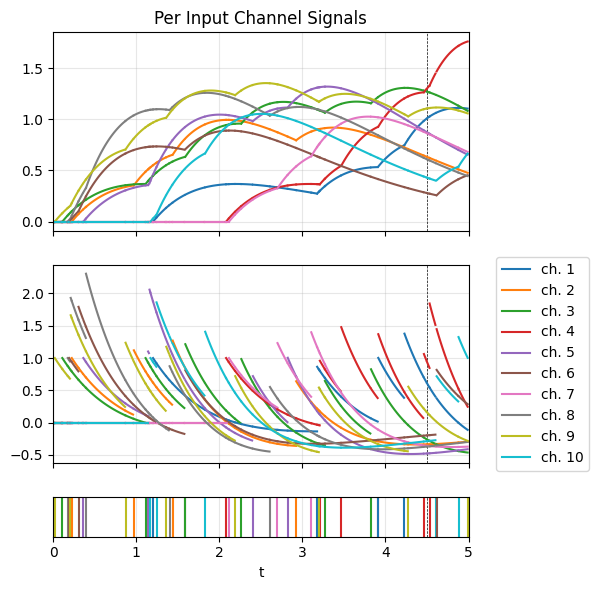

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True, height_ratios=(5, 5, 1))

for (in_time, in_channel) in zip(in_times, in_channels):
    axes[2].axvline(in_time, color=f'C{in_channel}')

for i in range(3):
    axes[i].axvline(f_time - eps, color=f'black', linewidth=0.5, linestyle='--', label='_nolegend_')

axes[2].set_xlabel('t')
axes[0].set_title('Per Input Channel Signals')
# axes[2].set_ylabel('Spikes')
axes[2].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(0, f_time)

for start_n, length_n, ck0_n, ck1_n in zip(start, length, ck0, ck1):
    # for k in range(neuron.n_in_channels):
    for k in range(n_in_channels):
        dt_vals = np.arange(0, length_n, 1e-2)
        t_vals = dt_vals + start_n
        y_vals = (ck0_n[k] + ck1_n[k] * dt_vals) * np.exp(-dt_vals)
        axes[0].plot(t_vals, y_vals, c=f"C{k}", linewidth=1.5)

        y_vals = (ck1_n[k] - ck0_n[k] - ck1_n[k] * dt_vals) * np.exp(-dt_vals)
        axes[1].plot(t_vals, y_vals, c=f"C{k}", linewidth=1.5)

axes[1].legend([f"ch. {k+1}" for k in range(n_in_channels)], bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)

plt.tight_layout()
plt.show()

In [6]:
n_in_channels = 10
n_in_times = 15
f_thresh = 1.0
zmax, dzmin = 0.0, 0.5
eps = 0.5
period = 10.0
f_time = 0.0
in_times = np.random.uniform(0.0, period, size=n_in_times)
in_channels = (np.random.randint(0, n_in_channels, size=n_in_times))

Feasible (trivial) solution found.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

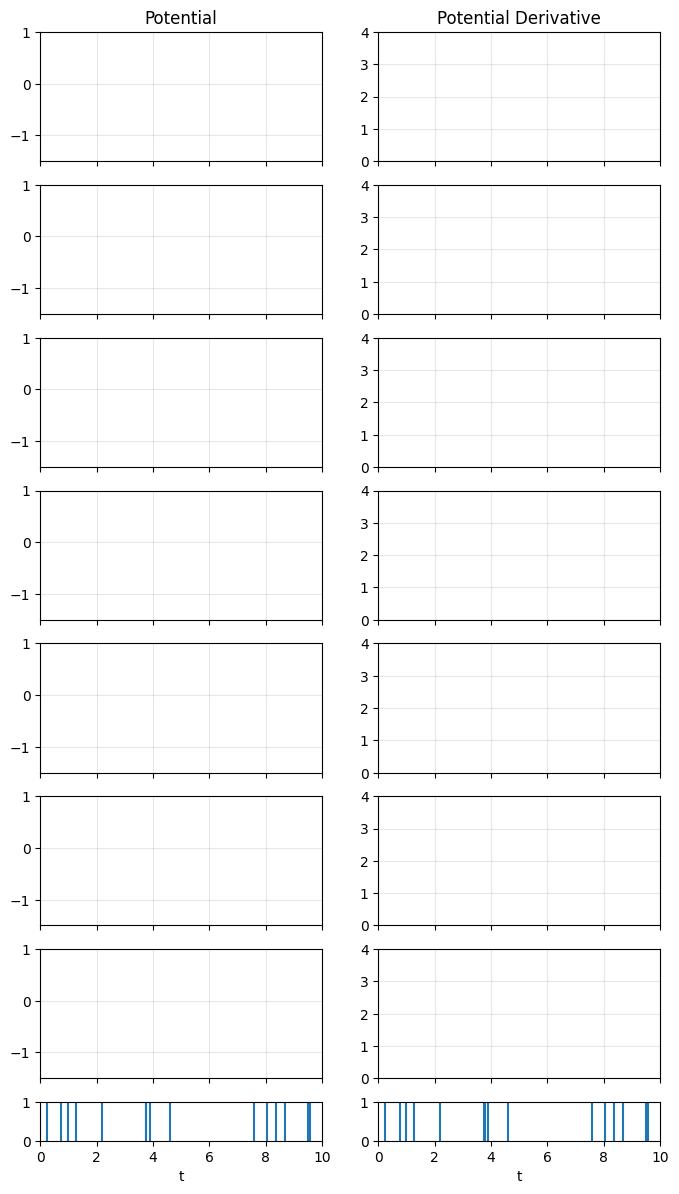

In [7]:
neuron = optim.Neuron()
feas_tol, conv_tol = 1e-2, 1e-12
n_iter = 7

if neuron.solver is None:
    neuron.init_solver(
        np.array([f_time]),
        in_times,
        in_channels,
        period=period,
        eps=eps,
        zmax=zmax,
        dzmin=dzmin,
        f_thresh=f_thresh
    )

fig, axes = plt.subplots(n_iter+1, 2, figsize=(8, 1.8 * (n_iter+1)), sharex=True, height_ratios=(1,)*n_iter + (0.3,))

axes[0][0].set_title("Potential")
axes[-1][0].set_xlabel("t")
axes[-1][0].set_xlim(0, 10.0)

axes[0][1].set_title("Potential Derivative")
axes[-1][1].set_xlabel("t")
axes[-1][1].set_xlim(0, 10.0)

for i in range(n_iter):
    axes[i][0].grid(True, alpha=0.3)
    axes[i][1].grid(True, alpha=0.3)
    axes[i][0].set_ylim(-1.5, f_thresh)
    axes[i][1].set_ylim(0, 4.0)

for in_time in in_times:
    axes[-1][0].axvline(in_time, color=f'C0')
    axes[-1][1].axvline(in_time, color=f'C0')

for i in range(n_iter):
    # 1. DCD algorithm: repeat the following steps until convergence (of the primal cost) or n_iter reached:
    # 1.1 dual coordinate descent step in the dual space
    # 1.2 convert the dual vector to a primal vector
    # 1.3 compute the cost of the primal vector
    res_dcd = neuron.solver.dual_coordinate_descent(feas_tol, conv_tol)
    if res_dcd == 1:
        neuron.z_c0 = (
            np.inner(neuron.z_ck0[:, :-1], neuron.solver.x) + neuron.z_ck0[:, -1]
        )
        neuron.z_c1 = (
            np.inner(neuron.z_ck1[:, :-1], neuron.solver.x) + neuron.z_ck1[:, -1]
        )
        z_imax, z_vmax, z_dtmax = optim.find_maximum(
            neuron.z_c0, neuron.z_c1, neuron.z_length, neuron.z_lim
        )

        neuron.dz_c0 = (
            np.inner(neuron.dz_ck0[:, :-1], neuron.solver.x) + neuron.dz_ck0[:, -1]
        )
        neuron.dz_c1 = (
            np.inner(neuron.dz_ck1[:, :-1], neuron.solver.x) + neuron.dz_ck1[:, -1]
        )
        dz_imax, dz_vmax, dz_dtmax = optim.find_maximum(
            neuron.dz_c0, neuron.dz_c1, neuron.dz_length, neuron.dz_lim
        )

        for start, length, c0, c1, lim in zip(
            neuron.z_start, neuron.z_length, neuron.z_c0, neuron.z_c1, neuron.z_lim
        ):
            dt_vals = np.arange(0, length, 1e-2)
            t_vals = dt_vals + start
            y_vals = (c0 + c1 * dt_vals) * np.exp(-dt_vals)
            axes[i][0].plot(t_vals, y_vals, linewidth=1.5, c="C0", label="__nolegend_")
        axes[i][0].fill_between(
            np.array([0, period - eps]), zmax, -1.5, color="C2", alpha=0.2, label="__nolegend_"
        )
        axes[i][0].fill_between(
            np.array([period-eps, period]), f_thresh, -1.5, color="C2", alpha=0.2, label="__nolegend_"
        )

        for start, length, c0, c1 in zip(
            neuron.dz_start, neuron.dz_length, neuron.dz_c0, neuron.dz_c1
        ):
            dt_vals = np.arange(0, length, 1e-2)
            t_vals = dt_vals + start
            y_vals = (c0 + c1 * dt_vals) * np.exp(-dt_vals)
            axes[i][1].plot(t_vals, -y_vals, linewidth=1.5, c="C0", label="__nolegend_")

        axes[i][1].fill_between(
            np.array([period-eps, period]), dzmin, 7.0, color="C2", alpha=0.2, label="__nolegend_"
        )


        if z_vmax <= feas_tol and dz_vmax <= feas_tol:
            print(f"Optimal solution found in {i+1} iterations.")
            break
        else:
            if z_vmax > dz_vmax:
                neuron.solver.add_constraint(
                    (neuron.z_ck0[z_imax, :-1] + z_dtmax * neuron.z_ck1[z_imax, :-1])
                    * np.exp(-z_dtmax),
                    neuron.z_lim[z_imax]
                    - (neuron.z_ck0[z_imax, -1] + z_dtmax * neuron.z_ck1[z_imax, -1])
                    * np.exp(-z_dtmax),
                )
                axes[i][0].axvline(
                    neuron.z_start[z_imax] + z_dtmax,
                    color="C1",
                    linestyle="--",
                    linewidth=1,
                    alpha=0.5,
                    label=rf"$t_c={neuron.z_start[z_imax] + z_dtmax:.2f}$",
                )
                axes[i][0].scatter(
                    neuron.z_start[z_imax] + z_dtmax,
                    z_vmax + neuron.z_lim[z_imax],
                    color="C1",
                    label=rf"$z(t_c) = {z_vmax + neuron.z_lim[z_imax]:.2f} > {neuron.z_lim[z_imax]:.2f}$",
                )
                axes[i][0].legend()

            else:
                neuron.solver.add_constraint(
                    (
                        neuron.dz_ck0[dz_imax, :-1]
                        + dz_dtmax * neuron.dz_ck1[dz_imax, :-1]
                    )
                    * np.exp(-dz_dtmax),
                    neuron.dz_lim[dz_imax]
                    - (
                        neuron.dz_ck0[dz_imax, -1]
                        + dz_dtmax * neuron.dz_ck1[dz_imax, -1]
                    )
                    * np.exp(-dz_dtmax),
                )
                axes[i][1].axvline(
                    neuron.dz_start[dz_imax] + dz_dtmax,
                    color="C1",
                    linestyle="--",
                    linewidth=1,
                    alpha=0.5,
                    label=rf"$t_c={neuron.dz_start[dz_imax] + dz_dtmax:.2f}$",
                )
                axes[i][1].scatter(
                    neuron.dz_start[dz_imax] + dz_dtmax,
                    -dz_vmax - neuron.dz_lim[dz_imax],
                    color="C1",
                    label=rf"$\dot z (t_c) = {-dz_vmax - neuron.dz_lim[dz_imax]:.2f}$",
                )
                axes[i][1].legend()
    else:
        break

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
n_in_channels = 10
n_in_times = 15
f_thresh = 1.0
zmax, dzmin = 0.0, 0.5
eps = 0.5
period = 10.0
in_times = np.random.uniform(0.0, period, size=n_in_times)
in_channels = (np.random.randint(0, n_in_channels, size=n_in_times))

Feasible (trivial) solution found.


NameError: name 'z_vmax' is not defined

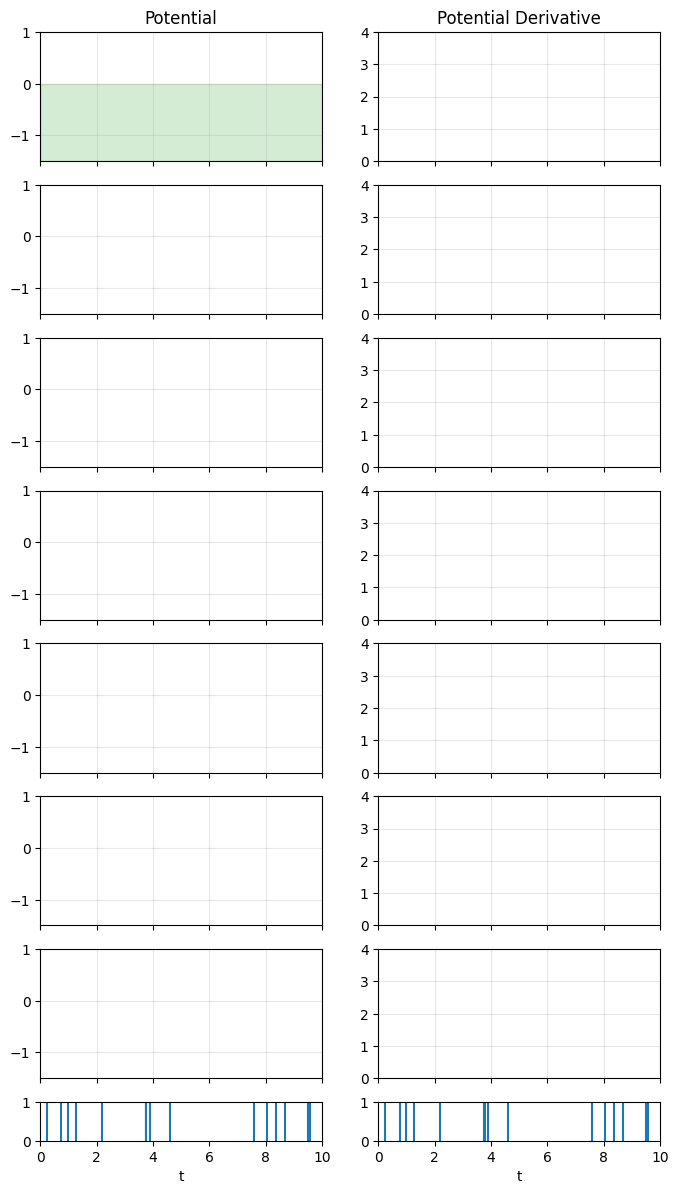

In [8]:
neuron = optim.Neuron()
feas_tol, conv_tol = 1e-3, 1e-9
n_iter = 7

if neuron.solver is None:
    neuron.init_solver(
        np.array([]),
        in_times,
        in_channels,
        period=period,
        eps=eps,
        zmax=zmax,
        dzmin=dzmin,
        f_thresh=f_thresh
    )

fig, axes = plt.subplots(n_iter+1, 2, figsize=(8, 1.8 * (n_iter+1)), sharex=True, height_ratios=(1,)*n_iter + (0.3,))

axes[0][0].set_title("Potential")
axes[-1][0].set_xlabel("t")
axes[-1][0].set_xlim(0, 10.0)

axes[0][1].set_title("Potential Derivative")
axes[-1][1].set_xlabel("t")
axes[-1][1].set_xlim(0, 10.0)

for i in range(n_iter):
    axes[i][0].grid(True, alpha=0.3)
    axes[i][1].grid(True, alpha=0.3)
    axes[i][0].set_ylim(-1.5, f_thresh)
    axes[i][1].set_ylim(0, 4.0)

for in_time in in_times:
    axes[-1][0].axvline(in_time, color=f'C0')
    axes[-1][1].axvline(in_time, color=f'C0')

zvmax = -np.inf
dzvmax = -np.inf

for i in range(n_iter):
    # 1. DCD algorithm: repeat the following steps until convergence (of the primal cost) or n_iter reached:
    # 1.1 dual coordinate descent step in the dual space
    # 1.2 convert the dual vector to a primal vector
    # 1.3 compute the cost of the primal vector
    res_dcd = neuron.solver.dual_coordinate_descent(feas_tol, conv_tol)
    if res_dcd == 1:
        if neuron.n_z_intervals > 0:
            neuron.z_c0 = (
                np.inner(neuron.z_ck0[:, :-1], neuron.solver.x) + neuron.z_ck0[:, -1]
            )
            neuron.z_c1 = (
                np.inner(neuron.z_ck1[:, :-1], neuron.solver.x) + neuron.z_ck1[:, -1]
            )
            z_imax, z_vmax, z_dtmax = optim.find_maximum(
                neuron.z_c0, neuron.z_c1, neuron.z_length, neuron.z_lim
            )

        if neuron.n_dz_intervals > 0:
            neuron.dz_c0 = (
                np.inner(neuron.dz_ck0[:, :-1], neuron.solver.x) + neuron.dz_ck0[:, -1]
            )
            neuron.dz_c1 = (
                np.inner(neuron.dz_ck1[:, :-1], neuron.solver.x) + neuron.dz_ck1[:, -1]
            )
            dz_imax, dz_vmax, dz_dtmax = optim.find_maximum(
                neuron.dz_c0, neuron.dz_c1, neuron.dz_length, neuron.dz_lim
            )

        for start, length, c0, c1, lim in zip(
            neuron.z_start, neuron.z_length, neuron.z_c0, neuron.z_c1, neuron.z_lim
        ):
            dt_vals = np.arange(0, length, 1e-2)
            t_vals = dt_vals + start
            y_vals = (c0 + c1 * dt_vals) * np.exp(-dt_vals)
            axes[i][0].plot(t_vals, y_vals, linewidth=1.5, c="C0", label="__nolegend_")
        axes[i][0].fill_between(
            np.array([0, period]), zmax, -1.5, color="C2", alpha=0.2, label="__nolegend_"
        )

        for start, length, c0, c1 in zip(
            neuron.dz_start, neuron.dz_length, neuron.dz_c0, neuron.dz_c1
        ):
            dt_vals = np.arange(0, length, 1e-2)
            t_vals = dt_vals + start
            y_vals = (c0 + c1 * dt_vals) * np.exp(-dt_vals)
            axes[i][1].plot(t_vals, -y_vals, linewidth=1.5, c="C0", label="__nolegend_")


        if z_vmax <= feas_tol and dz_vmax <= feas_tol:
            print(f"Optimal solution found in {i+1} iterations.")
            break
        else:
            if z_vmax > dz_vmax:
                print("ADD POTENTIAL CONSTRAINT")
                print(f"z_vmax = {z_vmax}, z_dtmax = {z_dtmax}")
                neuron.solver.add_constraint(
                    (neuron.z_ck0[z_imax, :-1] + z_dtmax * neuron.z_ck1[z_imax, :-1])
                    * np.exp(-z_dtmax),
                    neuron.z_lim[z_imax]
                    - (neuron.z_ck0[z_imax, -1] + z_dtmax * neuron.z_ck1[z_imax, -1])
                    * np.exp(-z_dtmax),
                )
                axes[i][0].axvline(
                    neuron.z_start[z_imax] + z_dtmax,
                    color="C1",
                    linestyle="--",
                    linewidth=1,
                    alpha=0.5,
                    label=rf"$t_c={neuron.z_start[z_imax] + z_dtmax:.2f}$",
                )
                axes[i][0].scatter(
                    neuron.z_start[z_imax] + z_dtmax,
                    z_vmax + neuron.z_lim[z_imax],
                    color="C1",
                    label=rf"$z(t_c) = {z_vmax + neuron.z_lim[z_imax]:.2f} > {neuron.z_lim[z_imax]:.2f}$",
                )
                axes[i][0].legend()

            else:
                print("ADD POTENTIAL DERIVATIVE CONSTRAINT")
                print(f"dz_vmax = {dz_vmax}, dz_dtmax = {dz_dtmax}")
                neuron.solver.add_constraint(
                    (
                        neuron.dz_ck0[dz_imax, :-1]
                        + dz_dtmax * neuron.dz_ck1[dz_imax, :-1]
                    )
                    * np.exp(-dz_dtmax),
                    neuron.dz_lim[dz_imax]
                    - (
                        neuron.dz_ck0[dz_imax, -1]
                        + dz_dtmax * neuron.dz_ck1[dz_imax, -1]
                    )
                    * np.exp(-dz_dtmax),
                )
                axes[i][1].axvline(
                    neuron.dz_start[dz_imax] + dz_dtmax,
                    color="C1",
                    linestyle="--",
                    linewidth=1,
                    alpha=0.5,
                    label=rf"$t_c={neuron.dz_start[dz_imax] + dz_dtmax:.2f}$",
                )
                axes[i][1].scatter(
                    neuron.dz_start[dz_imax] + dz_dtmax,
                    -dz_vmax - neuron.dz_lim[dz_imax],
                    color="C1",
                    label=rf"$\dot z (t_c) = {-dz_vmax - neuron.dz_lim[dz_imax]:.2f}$",
                )
                axes[i][1].legend()
    else:
        break

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
raise NotImplementedError("The rest of the code is not implemented yet.")

NotImplementedError: The rest of the code is not implemented yet.

In [9]:
n_in_channels = 10
n_in_times = 15
f_thresh = 1.0
zmax, dzmin = 0.0, 0.5
eps = 0.5
period = 10.0
in_times = np.random.uniform(0.0, period, size=n_in_times)
in_channels = (np.random.randint(0, n_in_channels, size=n_in_times))

neuron = optim.Neuron()
neuron.init_solver(
        np.array([]),
        in_times,
        in_channels,
        period=period,
        eps=eps,
        zmax=zmax,
        dzmin=dzmin,
        f_thresh=f_thresh
    )
neuron.learn()

Feasible (trivial) solution found.
Solved in 1 iterations! Cost is 0.000 for 0 constraints.


/Users/haguettaz/Desktop/RSNN/src/rsnn/optim.py:108: RuntimeWarning: invalid value encountered in divide
  ts = np.where(c1 <= 0, 0.0, np.clip(1 - c0 / c1, 0.0, length))


1

In [13]:
n_in_channels = 500
n_in_times = 1000
f_thresh = 1.0
zmax, dzmin = 0.0, 1.0
eps = 0.5
period = 10.0
f_time = 0.0
in_times = np.random.uniform(0.0, period, size=n_in_times)
in_channels = (np.random.randint(0, n_in_channels, size=n_in_times))

neuron = optim.Neuron()
neuron.init_solver(
        np.array([f_time]),
        in_times,
        in_channels,
        period=period,
        eps=eps,
        zmax=zmax,
        dzmin=dzmin,
        f_thresh=f_thresh
    )
neuron.learn()

Converged after 2 iterations with cost 0.13912987768944077
Feasible solution found.
Converged after 5 iterations with cost 0.23628863275941986
Feasible solution found.
Converged after 203 iterations with cost 0.47889714631300867
Feasible solution found.
Converged after 131 iterations with cost 0.48271780695309785
Feasible solution found.
Converged after 71 iterations with cost 0.48272430204011924
Feasible solution found.
Solved in 5 iterations! Cost is 0.483 for 5 constraints.


1

# Determining the critical points

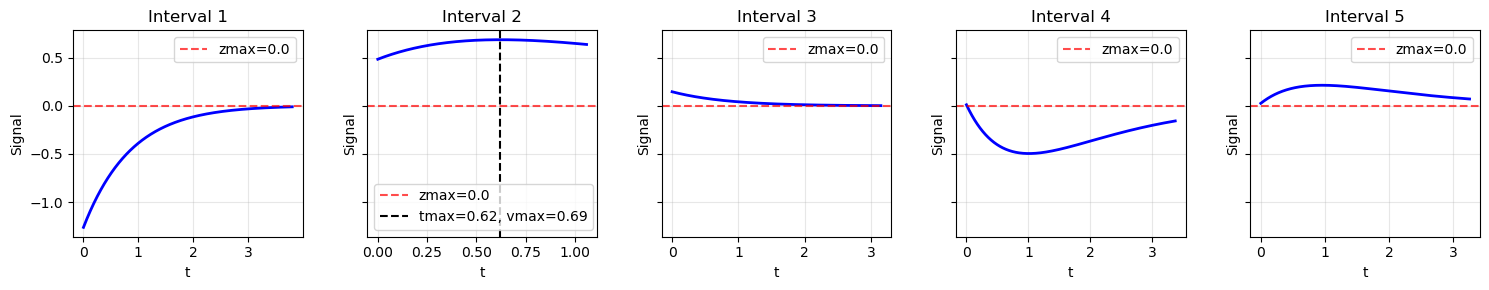

In [ ]:
in_coef = np.random.randn(2, 5, 10) / np.sqrt(10)  # shape (2, n_inputs, n_intervals)
ends = np.random.uniform(0, 5, size=5)  # shape (n_intervals,)
weights = np.random.randn(10)  # shape (n_inputs,)
zmax = 0.0  # some threshold value
coef = np.inner(in_coef, weights)  # shape (2, n_intervals)

imax, tmax, vmax = critical_potential(coef, ends, zmax)

fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)

for i in range(5):
    t_vals = np.linspace(0, ends[i], 1000)
    y_vals = (coef[0, i] + coef[1, i] * t_vals) * np.exp(-t_vals)
    
    axes[i].plot(t_vals, y_vals, 'b-', linewidth=2)
    axes[i].axhline(y=zmax, color='r', linestyle='--', alpha=0.7, label=f'zmax={zmax}')
    axes[i].set_xlabel('t')
    axes[i].set_ylabel('Signal')
    axes[i].set_title(f'Interval {i+1}')
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_xlim(0, ends[i])
    axes[i].legend()

axes[imax].axvline(tmax, color='black', linestyle='--', label=f'tmax={tmax:.2f}, vmax={vmax:.2f}')
axes[imax].legend()

plt.tight_layout()
plt.show()

In [ ]:
coef[:, 2]
ts = np.clip(1 - coef[0,2] / coef[1,2], 0.0, ends[2])  # t = 1 - c0 / c1, the clipping also handles the case c1 = 0
vs = np.maximum(coef[0,2], (coef[0,2] + coef[1,2] * ts) * np.exp(-ts))
ts, vs

(np.float64(0.02153725776080251), np.float64(2.03236525539423))

In [ ]:
a = ((in_coef[0, imax] + tmax * in_coef[1, imax]) * np.exp(-tmax)).reshape(1, -1)
b = np.array([zmax])

In [ ]:
from dataclasses import dataclass


@dataclass
class InSpike:
    conn_id: int
    time: float


period = 100.0

n_f_times = 3
f_times = np.random.uniform(0, 100, size=n_f_times)
f_times = np.sort(f_times)
s0 = f_times[0]
# f_times = np.concatenate(
#     (np.array([f_times[-1] - period]), f_times, np.array([f_times[0] + period]))
# )
f_times -= s0
starts = np.append(f_times, period)
# ends = np.roll(f_times, -1)
# ends[-1] = period
f_times, starts

(array([ 0.        , 38.60756882, 50.88000478]),
 array([  0.        ,  38.60756882,  50.88000478, 100.        ]))

In [ ]:
# note: make sure in_spikes are in [0, period]
n_inputs = 6
n_in_spikes = 5
in_spikes = [
    InSpike(conn_id=np.random.randint(0, n_inputs), time=np.random.uniform(0, period))
    for _ in range(n_in_spikes)
] 
in_spikes.sort(key=lambda x: x.time)
in_ids = np.array([spike.conn_id for spike in in_spikes])
in_times = np.array([spike.time for spike in in_spikes])
# in_times = np.array([(spike.time - s0) % period for spike in in_spikes])

# find the interval indices for each input spike time
in_int = np.searchsorted(starts, in_times, side='right') - 1

in_times, starts

(array([ 2.6875488 ,  6.16243931, 53.41486702, 63.2614007 , 81.01977437]),
 array([  0.        ,  38.60756882,  50.88000478, 100.        ]))

In [ ]:
# correspond to the first interval, now needs to compute the subintervals
in_times[in_int == 0], in_ids[in_int == 0], starts[0], starts[1]

(array([2.6875488 , 6.16243931]),
 array([4, 1]),
 np.float64(0.0),
 np.float64(38.60756882432332))

In [ ]:
# we first consider only one interval (0, s] where s is the desired firing time
# assume the neuron receives n_in_spikes spikes from n_inputs inputs during the interval [0, s)
# there are n_in_spikes intervals to consider
# in_times and in_channels are the spike times and their corresponding input indices
n_in_times = 5
n_in_channels = 4
f_time = 42.0

in_times = np.sort(np.random.uniform(0, f_time, size=n_in_times))
in_channels = np.random.randint(0, n_in_channels, size=n_in_times)  # random input channels for the spikes

# we assume the n_in_times are sorted
# and we have 0 <= t_i < s for all t_i in in_times
in_coef = np.zeros((2, n_in_times, n_in_channels))  # shape (n_inputs, 2)
tmp_ind = np.arange(n_in_times)
in_coef[1, tmp_ind, in_channels[tmp_ind]] += 1.0
for n in range(1, n_in_times):
    dt = in_times[n] - in_times[n - 1]
    in_coef[0,n] += (in_coef[0, n-1] + in_coef[0, n-1] * dt) * np.exp(-dt)
    in_coef[1,n] += in_coef[1, n-1] * np.exp(-dt)

ends = np.diff(in_times, append=f_time)

In [ ]:
def init_in_coef(f_times:np.ndarray, in_times:np.ndarray, in_channels:np.ndarray, n_in_channels:np.intp) -> np.ndarray:
    # now, consider many firing times, each having its own subintervals
    # period = 100.0
    # n_f_times = 3
    # f_times = np.sort(np.random.uniform(0, period, size=n_f_times))
    # n_in_times = 5
    # n_in_channels = 4
    # in_times = np.sort(np.random.uniform(0, f_times[-1], size=n_in_times))
    # in_channels = np.random.randint(0, n_in_channels, size=n_in_times)  # random input channels for the spikes

    # assume ti < f_times[-1] for every ti in_times
    f_times = np.sort(f_times) # not necessary??
    in_times = np.sort(in_times)

    in_coef = np.zeros((2, in_times.size, n_in_channels))  # shape (n_inputs, 2)
    
    # compute the insertion positions of the firing times in the input times array
    ipos = np.searchsorted(in_times, f_times, side='left')  # number of intervals for each firing time
    ipos = np.append(ipos, in_times.size)
    ipos = np.unique(ipos)

    print(f"f_times: {f_times}")
    print(f"in_times: {in_times}")
    print(f"in_channels: {in_channels}")

    n0 = 0
    for nmax in ipos:
        in_coef[1, n0, in_channels[n0]] = 1.0
        for n in range(n0+1, nmax):
            dt = in_times[n] - in_times[n - 1]
            in_coef[0,n] += (in_coef[0, n-1] + in_coef[1, n-1] * dt) * np.exp(-dt)
            in_coef[1,n] += in_coef[1, n-1] * np.exp(-dt)
            in_coef[1, n, in_channels[n]] += 1.0
        n0 = nmax


    # n_inter depends on the number of input spikes but also on the template itself 
    # we need to return:
    #  in_coef, an array with shape (2, n_inter, n_channels)
    #  zmax, an array with shape (n_inter)
    #  ends, an array with shape (n_inter)
    # all are computed from the template

    # 

    return in_coef

In [ ]:
eps = 10.0
period = 100.0
n_f_times = 5
n_in_times = 10

f_times = np.sort(np.random.uniform(0, period, size=n_f_times))
in_times = np.sort(np.random.uniform(0, f_times[-1], size=n_in_times))
bf_times = f_times - eps
print(f"bf_times: {bf_times}")
print(f"f_times: {f_times}")
print(f"in_times: {in_times}")

bf_times: [-8.17821464 16.84273824 31.8841312  45.79219783 76.65783549]
f_times: [ 1.82178536 26.84273824 41.8841312  55.79219783 86.65783549]
in_times: [ 0.49178469  3.1180875   7.14583659 25.74915188 34.08348035 64.30034582
 67.57301143 77.44500688 78.55799656 81.21936233]


In [ ]:
i = 1 # ith interval
b_indices = np.searchsorted(in_times, bf_times, side='left') - 1
indices = np.searchsorted(in_times, f_times, side='left') - 1
print(f"the {i}th interval [{bf_times[i]}, {f_times[i]}) overlaps the states induced by all in_times between {in_times[b_indices[i]]} and {in_times[indices[i]]}")

the 1th interval [16.842738235978658, 26.842738235978658) overlaps the states induced by all in_times between 7.145836589856869 and 25.74915187873333


# Input Signals Via Piecewise Fading Linear Functions

In [ ]:
# another alternative is to compute the coefficients one firing window at a time
from typing import Tuple
import numpy as np


def compute_in_states(
    f_time: np.float32,
    bf_time: np.float32,
    in_times: np.ndarray,
    in_channels: np.ndarray,
    n_in_channels: np.intp,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the coefficients (c0nk and c1nk) defining the states of every input (indexed by k) for any time between 0 and f_time, on disjoint intervals (indexed by n).
    The intervals partition the time range [0, f_time] in n_intervals = in_times.size + 3 intervals from the following time markers:
    - 0.0, the start of the time range
    - bf_time, the time before firing (the beginning of the active region)
    - f_time, the firing time
    - in_times, the input spike times.
    The intervals are reconstructed from their start and length.
    The signal (c0nk + c1nk * dt) * exp(-dt) for 0 <= dt < length[n] then corresponds to 
    a) the kth input signal on the nth interval [start[n], start[n] + length[n]) if start[n] + length[n] < bf_time.
    b) the derivative of the kth input signal on the nth interval [start[n], start[n] + length[n]) if start[n] + length[n] < f_time and start[n] >= f_time.
    c) the kth input signal on the nth interval [start[n], start[n] + length[n]) if start[n] = f_time.

    Args:
        f_time (np.float32): _description_
        bf_time (np.float32): _description_
        in_times (np.ndarray): _description_
        in_channels (np.ndarray): _description_
        n_in_channels (np.intp): _description_

    Returns:
        np.ndarray: the coefficients defining the input signals by parts with shape (2, n_intervals, n_channels)
        np.ndarray: the times at which the intervals start with shape (n_intervals)
        np.ndarray: the lengths the intervals, with shape (n_intervals)
    """
    # Extract the in_times and in_channels that are valid, i.e., within the range [0, f_time)
    valid = (in_times >= 0.0) & (in_times < f_time)
    in_times = in_times[valid]
    in_channels = in_channels[valid]

    # Initialize the starts array
    starts = np.concatenate((in_times, np.array([0.0, f_time, bf_time])))

    # Initialize the coefficients array
    in_coef = np.zeros((2, starts.size, n_in_channels))
    in_coef[1, np.arange(in_times.size), in_channels] = 1.0

    # Sort the coefficients according to their starts
    sort_ids = np.argsort(starts)
    starts = starts[sort_ids]
    lengths = np.diff(starts, append=f_time)  # time differences = lengths of the intervals
    # ends = starts + lengths

    in_coef = in_coef[:, sort_ids, :]
    for n in range(starts.size - 1):
        in_coef[1, n + 1] += in_coef[1, n] * np.exp(-lengths[n])
        in_coef[0, n + 1] += (in_coef[0, n] + in_coef[1, n] * lengths[n]) * np.exp(-lengths[n])

    # The signal of interest on the active region is the (negative) derivative
    active = (starts >= bf_time) & (starts < f_time)
    in_coef[0, active] -= in_coef[1, active]  # (negative) derivative

    return in_coef, starts, lengths

In [ ]:
f_time = 100.0
n_in_times = 50
n_in_channels = 5

in_times = np.random.uniform(0, f_time, size=n_in_times)
in_channels = np.random.randint(0, n_in_channels, size=n_in_times)

In [ ]:
bf_time = f_time
in_coef, starts, durations = compute_in_states(f_time, bf_time, in_times, in_channels, n_in_channels)

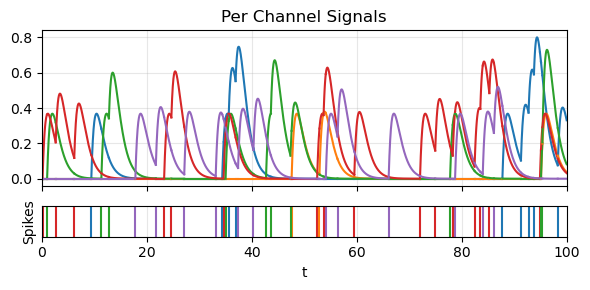

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, height_ratios=(5, 1))

for n in range(in_coef.shape[1]):
    for k in range(n_in_channels):
        dt_vals = np.arange(0, durations[n], 1e-2)
        t_vals = dt_vals + starts[n]
        y_vals = (in_coef[0, n, k] + in_coef[1, n, k] * dt_vals) * np.exp(-dt_vals)
        axes[0].plot(t_vals, y_vals, c=f"C{k}", linewidth=1.5)
        

for n in range(in_times.size):
    axes[1].axvline(in_times[n], color=f'C{in_channels[n]}')

axes[1].set_xlabel('t')
axes[0].set_title('Per Channel Signals')
axes[1].set_ylabel('Spikes')
axes[1].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[0].set_xlim(0, 100.0)
# axes[1].legend([f"ch. {k+1}" for k in range(n_in_channels)], bbox_to_anchor=(0.5, -1.55), loc='upper center', ncol=5)

plt.tight_layout()
plt.show()

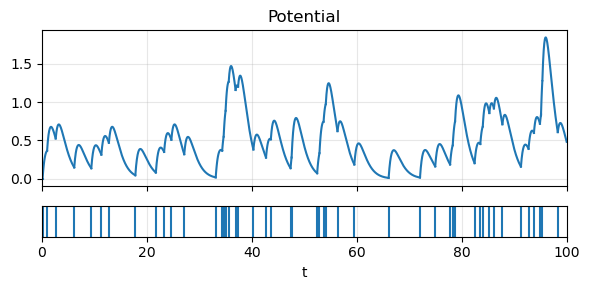

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, height_ratios=(5, 1))

for n in range(in_coef.shape[1]):
    dt_vals = np.arange(0, durations[n], 1e-2)
    t_vals = dt_vals + starts[n]
    y_vals = (np.sum(in_coef[0, n]) + np.sum(in_coef[1, n]) * dt_vals) * np.exp(-dt_vals)
    axes[0].plot(t_vals, y_vals, c="C0", linewidth=1.5)
        

for n in range(in_times.size):
    axes[1].axvline(in_times[n], color='C0')

axes[1].set_xlabel('t')
axes[0].set_title('Potential')
axes[1].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[0].set_xlim(0, 100.0)

plt.tight_layout()
plt.show()

In [ ]:
bf_time = 0.0
in_coef, starts, durations = compute_in_states(f_time, bf_time, in_times, in_channels, n_in_channels)

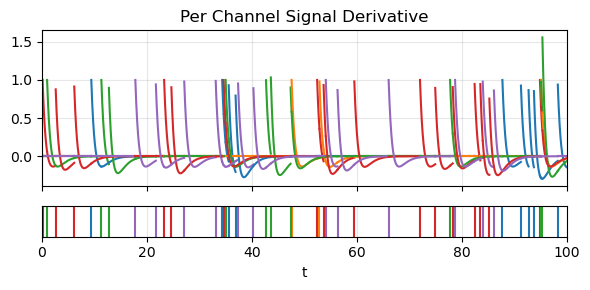

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, height_ratios=(5, 1))

for n in range(in_coef.shape[1]):
    for k in range(n_in_channels):
        dt_vals = np.arange(0, durations[n], 1e-2)
        t_vals = dt_vals + starts[n]
        y_vals = -(in_coef[0, n, k] + in_coef[1, n, k] * dt_vals) * np.exp(-dt_vals)
        axes[0].plot(t_vals, y_vals, c=f"C{k}", linewidth=1.5)
        

for n in range(in_times.size):
    axes[1].axvline(in_times[n], color=f'C{in_channels[n]}')

axes[1].set_xlabel('t')
axes[0].set_title('Per Channel Signal Derivative')
axes[1].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[0].set_xlim(0, 100.0)
# axes[0].legend([f"ch. {k+1}" for k in range(n_in_channels)], bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=5)

plt.tight_layout()
plt.show()

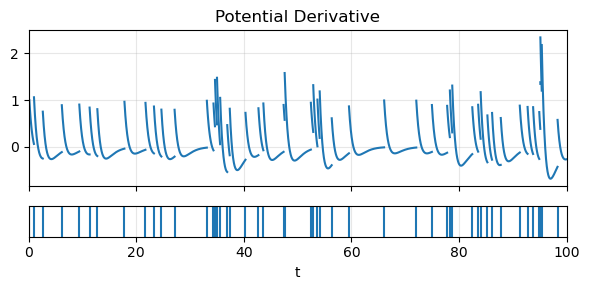

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, height_ratios=(5, 1))

for n in range(in_coef.shape[1]):
    dt_vals = np.arange(0, durations[n], 1e-2)
    t_vals = dt_vals + starts[n]
    y_vals = -(np.sum(in_coef[0, n]) + np.sum(in_coef[1, n]) * dt_vals) * np.exp(-dt_vals)
    axes[0].plot(t_vals, y_vals, c="C0", linewidth=1.5)
        

for n in range(in_times.size):
    axes[1].axvline(in_times[n], color='C0')

axes[1].set_xlabel('t')
axes[0].set_title('Potential Derivative')
# axes[1].set_ylabel('Spikes')
axes[1].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[0].set_xlim(0, 100.0)

plt.tight_layout()
plt.show()

In [ ]:
def mod(x, modulus, offset=0.0):
    """
    Compute the modulo operation with a given modulus and offset.
    """
    return x - modulus * np.floor((x - offset) / modulus)

# for n in n_f_times:
#     tmp_in_times = ((in_times % period) + period) % period

x = np.linspace(0, 5, 10)
y = mod(x, 5.0, offset=-1.0)
x, y

(array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
        2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ]),
 array([ 0.        ,  0.55555556,  1.11111111,  1.66666667,  2.22222222,
         2.77777778,  3.33333333,  3.88888889, -0.55555556,  0.        ]))

In [ ]:
period = 100.0
eps = 1.0

n_f_times = 5
n_in_times = 50
n_in_channels = 6

f_times = np.sort(np.random.uniform(0, period, size=n_f_times))
in_times = np.random.uniform(0, period, size=n_in_times)
in_channels = np.random.randint(0, n_in_channels, size=n_in_times)  # random input channels for the spikes


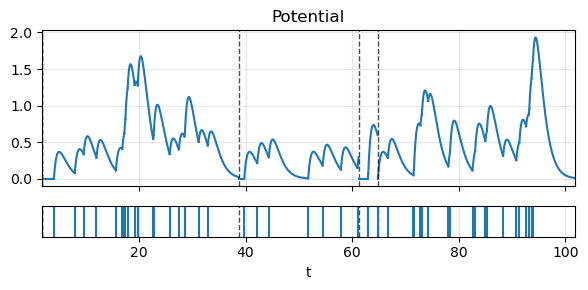

In [ ]:
# print(f"f_times: {f_times}")
# print(f"in_times: {in_times}")
# print(f"in_channels: {in_channels}")

fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, height_ratios=(5, 1))

for n in range(n_f_times):
    f_time = (f_times[n] - f_times[n - 1]) % period
    bf_time = f_time - eps
    in_coef, starts, durations = compute_in_states(
        f_time,
        f_time,
        (in_times - f_times[n - 1]) % period,
        in_channels,
        n_in_channels,
    )

    for m in range(in_coef.shape[1]):
        dt_vals = np.arange(0, durations[m], 1e-2)
        t_vals = dt_vals + starts[m] + f_times[n - 1]
        y_vals = (np.sum(in_coef[0, m]) + np.sum(in_coef[1, m]) * dt_vals) * np.exp(-dt_vals)
        axes[0].plot(t_vals, y_vals, c="C0", linewidth=1.5)

    axes[0].axvline(f_times[n], color='black', linestyle='--', linewidth=1.0, alpha=0.7)
    axes[1].axvline(f_times[n], color='black', linestyle='--', linewidth=1.0, alpha=0.7)
        
for m in range(in_times.size):
    axes[1].axvline((in_times[m] - f_times[0])%period + f_times[0], color='C0')

axes[1].set_xlabel('t')
axes[0].set_title('Potential')
axes[1].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[0].set_xlim(f_times[0], f_times[0] + period)

plt.tight_layout()
plt.show()

In [ ]:
in_times[3] = starts[1]
in_times, np.searchsorted(starts, in_times, side='right') - 1 # so that a new spike can be added exactly at the moment a firing occurs, otherwise, use side='left' for the opposite behavior


(array([71.33503425, 77.81319448, 15.01865438, 38.60756882, 49.52205263]),
 array([2, 2, 0, 1, 1]))

In [ ]:
# How to efficiently switch between in_coef and coef?
# coef should define the potential on the intervals (0, ends) or (starts, ends)
# they should be easily computed from in_coef and the weights
# we can probably 

array([  0.        ,  38.60756882,  50.88000478, 100.        ])

In [ ]:
coef 

In [ ]:
in_coef = np.random.randn(2, 0, 10) / np.sqrt(10)  # shape (2, n_inputs, n_intervals)
ends = np.random.uniform(0, 5, size=0)  # shape (n_intervals,)
weights = np.random.randn(10)  # shape (n_inputs,)
zmax = 0.0  # some threshold value
coef = np.inner(in_coef, weights)  # shape (2, n_intervals)

(imax, tmax, vmax) = critical_potential(in_coef, ends, weights, zmax)

TypeError: critical_potential() takes 3 positional arguments but 4 were given

In [ ]:
in_times = np.random.uniform(0, 5, size=10)
in_times.sort()
id = np.searchsorted(in_times, in_times[2], side='right')
id, in_times[id:], in_times

(np.int64(3),
 array([0.90826061, 1.37196686, 2.49940649, 2.5435063 , 2.67922178,
        3.34825177, 4.4945422 ]),
 array([0.06649748, 0.27871313, 0.41159789, 0.90826061, 1.37196686,
        2.49940649, 2.5435063 , 2.67922178, 3.34825177, 4.4945422 ]))

In [ ]:
%%timeit 
starts = np.random.uniform(0, 5, size=1000)
weights = np.random.randn(1000)
lengths = np.random.uniform(0.1, 1.0, size=1000)

ids = np.argsort(starts)
starts = starts[ids]
lengths = lengths[ids]
weights = weights[ids]

103 μs ± 4.07 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
starts = np.random.uniform(0, 5, size=1000)
weights = np.random.randn(1000)
lengths = np.random.uniform(0.1, 1.0, size=1000)

54.1 μs ± 1.79 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
states = np.empty((1000), dtype=[('start', 'f4'), ('length', 'f4'), ('weight', 'f4')])
states["start"] = np.random.uniform(0, 5, size=1000)
states["weight"] = np.random.randn(1000)
states["length"] = np.random.uniform(0.1, 1.0, size=1000)
states.sort(order='start')

588 μs ± 14.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%%timeit 
states = np.empty((1000), dtype=[('start', 'f4'), ('length', 'f4'), ('weight', 'f4')])
states["start"] = np.random.uniform(0, 5, size=1000)
states["weight"] = np.random.randn(1000)
states["length"] = np.random.uniform(0.1, 1.0, size=1000)

60.5 μs ± 2.28 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
n_states = 10

starts = np.random.uniform(0, 5, size=n_states)
weights = np.random.randn(n_states)
lengths = np.random.uniform(0.1, 1.0, size=n_states)
print(starts)

ids = np.argsort(starts)
starts = starts[ids]
lengths = lengths[ids]
weights = weights[ids]
print(starts)

# remove all states with a start time < 2.0
id = np.searchsorted(starts, 2.0, side='left')
starts = starts[id:]
lengths = lengths[id:]
weights = weights[id:]
print(starts)

[2.63491607 2.48902886 3.16693173 4.71848624 3.85999523 3.20347066
 0.33640457 1.36461836 4.88385506 1.83646752]
[0.33640457 1.36461836 1.83646752 2.48902886 2.63491607 3.16693173
 3.20347066 3.85999523 4.71848624 4.88385506]
[2.48902886 2.63491607 3.16693173 3.20347066 3.85999523 4.71848624
 4.88385506]


In [ ]:
%%timeit 
starts = np.random.uniform(0, 5, size=1000)
starts.sort()
weights = np.random.uniform(0.1, 1.0, size=1000)

59.6 μs ± 1.11 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
starts = np.random.uniform(0, 5, size=1000)
starts.sort()
weights = np.random.uniform(0.1, 1.0, size=1000)
starts = np.append(starts, -np.inf)
weights = np.append(weights, 0.0)
ids = np.argsort(starts)
starts = starts[ids]
weights = weights[ids]

79.2 μs ± 1.5 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
starts = np.random.uniform(0, 5, size=1000)
starts.sort()
weights = np.random.uniform(0.1, 1.0, size=1000)
starts = np.concatenate(([-np.inf], starts))
weights = np.concatenate(([0.0], weights))
# ids = np.argsort(starts)
# starts = starts[ids]
# weights = weights[ids]

62.9 μs ± 798 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
n_neurons = 100
r_f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]
f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]
dist = np.concatenate([(r_f_times_n[np.newaxis, :] - f_times_n[:, np.newaxis]).reshape(-1) for (r_f_times_n, f_times_n) in zip(r_f_times, f_times)])
dist.sort()

18.7 ms ± 643 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit 
n_neurons = 100
r_f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]
f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]
dist = np.concatenate([(r_f_times_n[np.newaxis, :] - f_times_n[:, np.newaxis]).flatten() for (r_f_times_n, f_times_n) in zip(r_f_times, f_times)])
dist.sort()

19 ms ± 173 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit 
n_neurons = 100
r_f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]
f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]

1.27 ms ± 13.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
times_1 = np.arange(3)
times_2 = np.arange(50, step=10)
(times_1[np.newaxis, :] + times_2[:, np.newaxis]).reshape(-1)
# (times_1[:, np.newaxis] + times_2[np.newaxis, :]).reshape(-1)

array([ 0,  1,  2, 10, 11, 12, 20, 21, 22, 30, 31, 32, 40, 41, 42])

In [ ]:
times = np.array([])
np.full(4, 1.0 / (1.0 * times.size))

ZeroDivisionError: float division by zero